In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

%matplotlib nbagg

np.random.seed(12345)

# Гама интеграл и Importance sampling

Ще разгледаме интеграла
$$ \int_0^1 x^\gamma\,dx = \frac{1}{1+\gamma}$$
при $\gamma > -1$. За $\gamma \le -1$ интегралът е разходящ.

Ще видим поведените на Монте Карло(МК) методите при различни стойности на $\gamma$.

## Директна извадка (Direct Sampling)

Директния МК изважда равномерно примери от цялата интеруема област ($(0,1)$ в случая), подадат се на функцията, която интегрираме ($f(x) = x^\gamma$ в случая) и усредняваме. Или преведено на Python:

In [3]:
def direct_gama(gamma, N):
    x = rand(N)
    return np.mean(x**gamma)

Да разгледаме поведението на горния алгоритъм в зависимост от $\gamma$ и $N$. За целта ще покажем графиката на МК оценката за интеграла срещу големината на извадката.

In [4]:
def direct_gama_running(gamma, N):
    x = rand(N)
    return np.cumsum(rand(N)**gamma)/np.arange(1, N+1)

Първо да разгледаме $\gamma=-0.2$. Да отбележим, че стойностите на функцията около 0 могат да стават произволно големи.

<IPython.core.display.Javascript object>


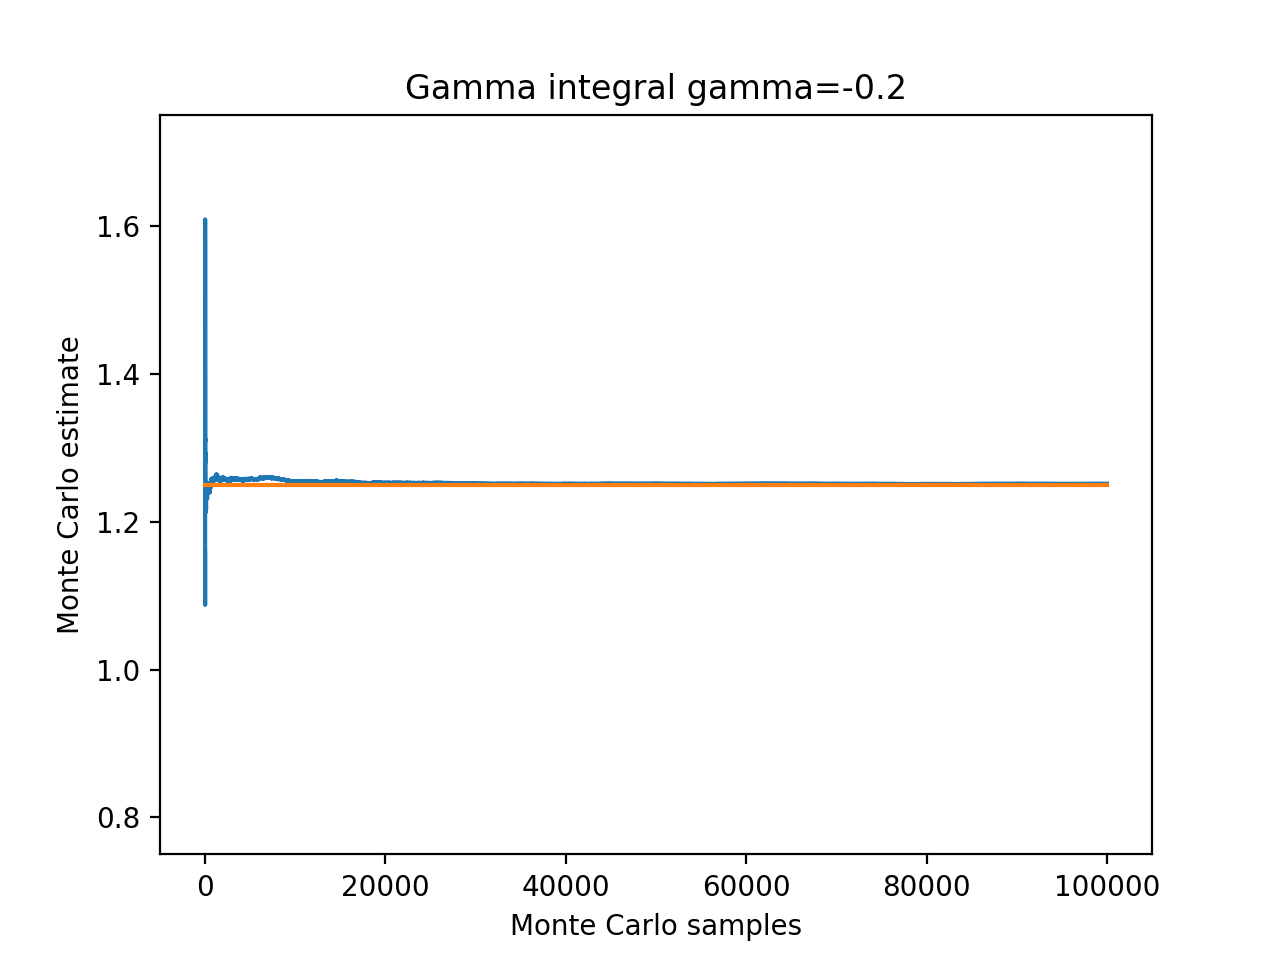

Text(0,0.5,'Monte Carlo estimate')

In [5]:
N = 100000
gamma = -0.2
exact= 1/(1+gamma)
plt.plot(np.arange(1, N+1), direct_gama_running(gamma, N), np.array([1, N]), np.array([exact, exact]), label='exact')

plt.title('Gamma integral gamma={}'.format(gamma))
plt.ylim((exact-0.5, exact+0.5))
plt.xlabel('Monte Carlo samples')
plt.ylabel('Monte Carlo estimate')

Да повторим същото за $\gamma=-0.7$.

<IPython.core.display.Javascript object>


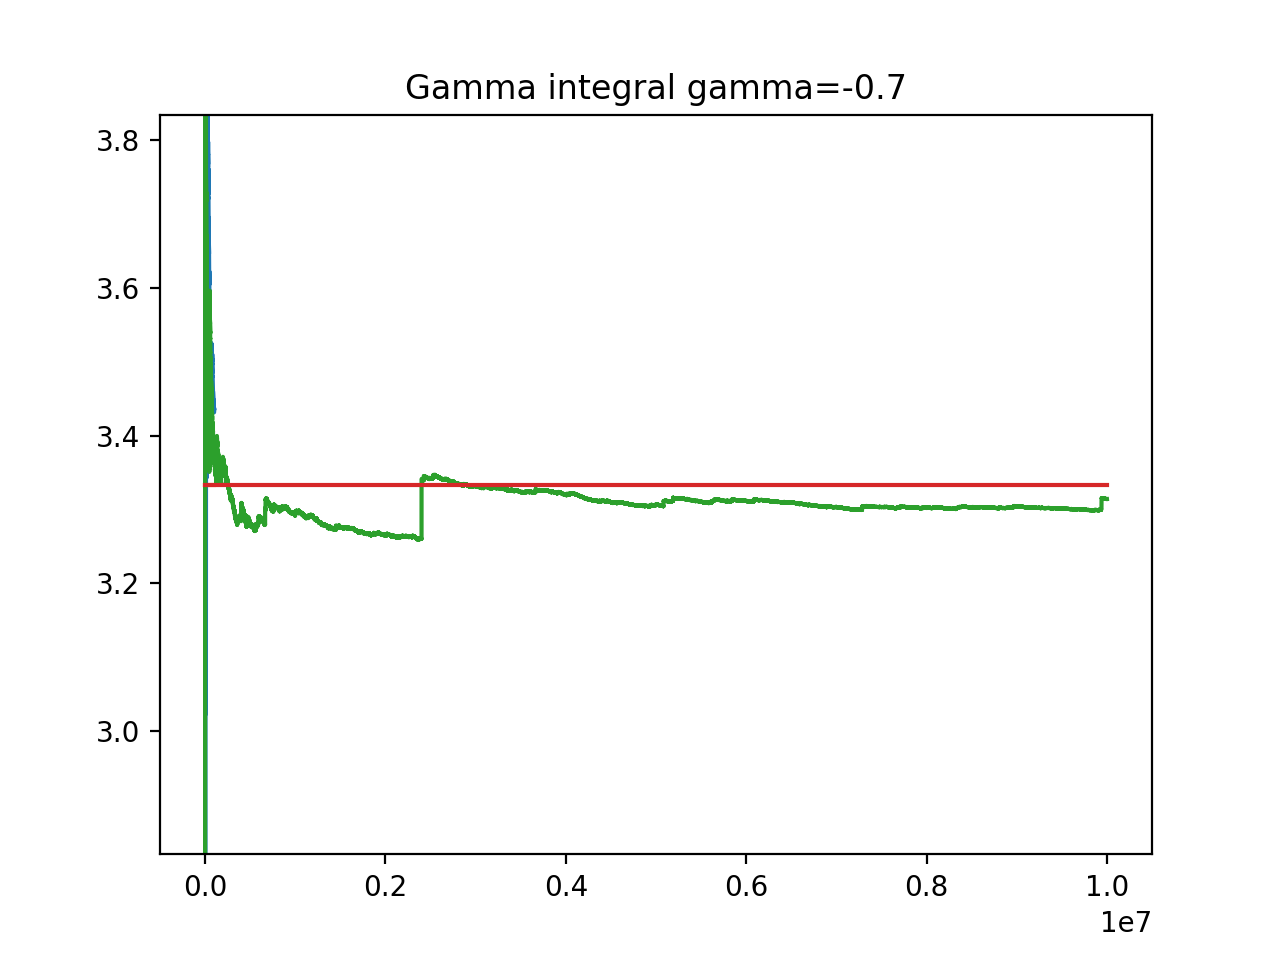

(2.833333333333333, 3.833333333333333)

In [6]:
N = 100000
gamma = -0.7
exact= 1/(1+gamma)
plt.plot(np.arange(1, N+1), direct_gama_running(gamma, N), np.array([1, N]), np.array([exact, exact]), label='exact')

plt.title('Gamma integral gamma={}'.format(gamma))
plt.ylim((exact-0.5, exact+0.5))

Резултатът понякога е над търсената стойност, понякога е под нея. Да опитаме с по-голямо $N$.

<IPython.core.display.Javascript object>


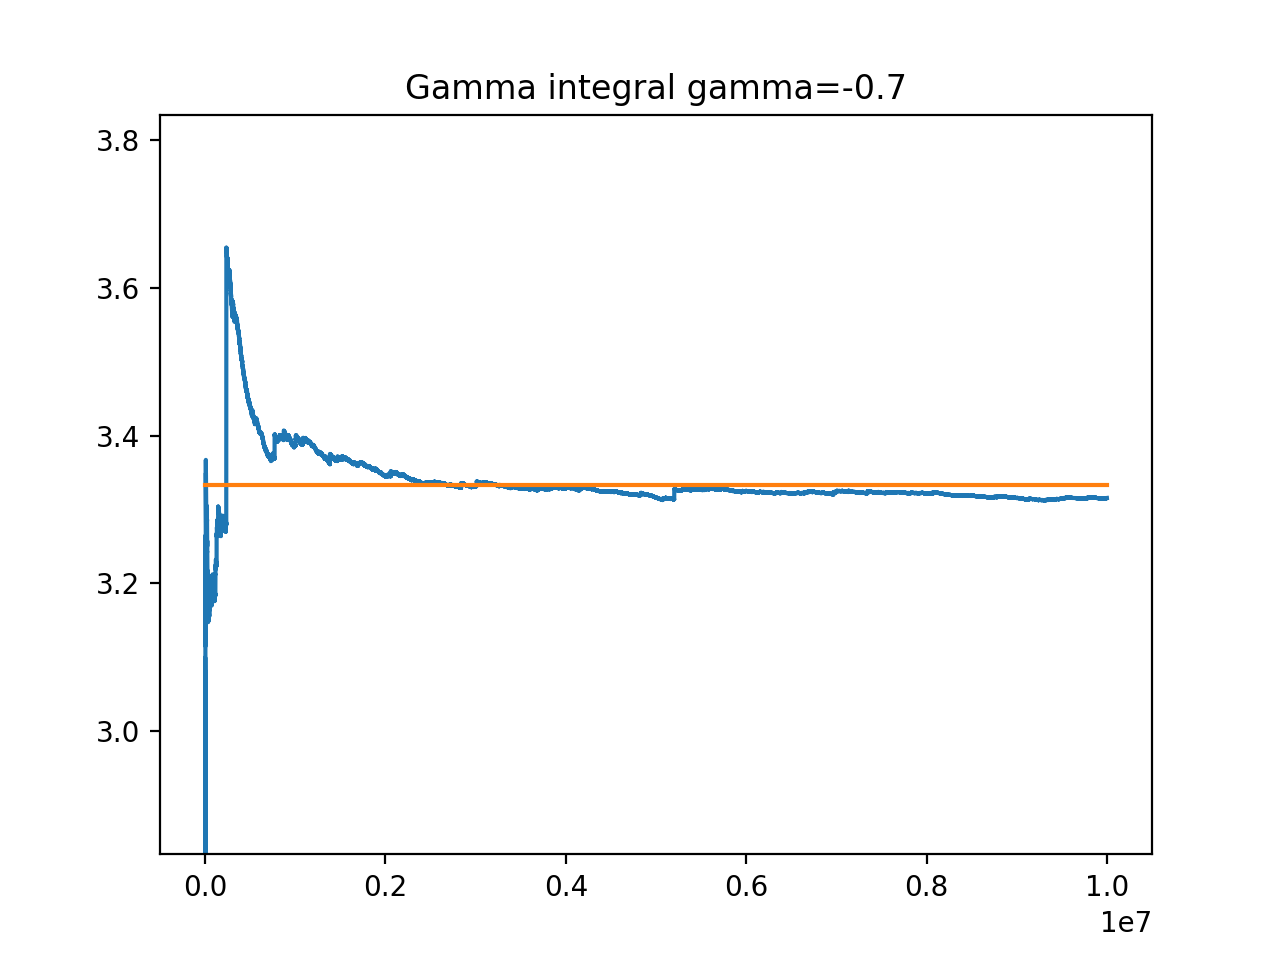

(2.833333333333333, 3.833333333333333)

In [8]:
N = 10000000

plt.plot(np.arange(1, N+1), direct_gama_running(gamma, N), np.array([1, N]), np.array([exact, exact]), label='exact')

plt.title('Gamma integral gamma={}'.format(gamma))
plt.ylim((exact-0.5, exact+0.5))

Отново не сме по-близко до точното решение.

Причината за различното поведение при $\gamma$ -0.2 и -0.7 е различнaта дисперсия на търсената функция. 
Нека я пресметнем.
$$\sigma^2(f(X)) = E(f(X)^2) - E(f(X))^2$$
$$E(f(X)^2) = \int_0^1 (x^\gamma)^2\,dx = \int_0^1 x^{2\gamma}\,dx$$
T.e. дисперсията е крайна само за $\gamma>-\frac{1}{2}$. Оценките за грешката са прпорционални на стандартното отклонение и в неравенството на Чебишев и в Централната гранична теорема.

## Приоритетни извадки (Importance Sampling)

Приоритетните извадки намаляват дисперцията. Да видим дали ще успеят да намалят безкрайната дисперсия.
Нека разгледаме случайна величина с плътност на разпредлението
$$ q(x) = \frac{x^\zeta}{1+\zeta} $$
Искаме да вземем извадка с това разпределение. Тъй като имаме разпределението в затворен вид, можем да направим това без отхвърляния (rejection rate=0). За целта намираме комулативната функция на разпределение:
$$ Q(y) = \int_0^y q(x)\,dx =  y^{1+\zeta}$$
За да генерираме q-разпределени случайни числа ползваме обратната ѝ функция $Q^{-1}(x) = x^{1/(1+\zeta)}$.

In [11]:
def direct_gama_zeta(gamma, zeta, N):
    x = rand(N)**(1/(1+zeta)) # q-distributed. RHS is Q^-1
    return np.cumsum(x**(gamma-zeta)/(zeta+1))/np.arange(1, N+1)

Формулата горе действително е равна на очакването от началото:
$$Е_p(f(X)) = \int_0^1 x^\gamma\,dx = \int_0^1 (1+\zeta) x^{\gamma-\zeta} \frac{x^\zeta}{1+\zeta }\,dx = \int_0^1 (1+\zeta) x^{\gamma-\zeta}\,dQ(x)$$
$dQ(x) = \frac{x^\zeta}{1+\zeta }\,dx$ е именно вероятностната мярка на q-разпределена случайна величина. 

Получената интегруема функция всъщност е равна на $f(x)\frac{p(x)}{q(x)}$, където $p(x)$ e плътността на първоначалното разпределение на $X$. Понеже е разпределено равномерно в $(0,1)$, $p(x)\equiv1$.

$\frac{p(x)}{q(x)}$ се нарича производна на Радон-Никодим и е обобщение на понятието производна за вероятностни разпределения.

### Намалена дисперсия

Дисперсията на новата функция е от порядъка на
$$E_q(\hat f (X)^2) = \int_0^1  ((1+\zeta) x^{\gamma-\zeta})^2 \frac{x^\zeta}{1+\zeta }\,dx = (1+\zeta)\int_0^1 x^{2\gamma-\zeta}\,dx  $$
Като q-то под Е означава очакване спрямо q-разпределена случайна величина и $\hat f (x) = f(x) \frac{p(x)}{q(x)} = (1+\zeta) x^{\gamma-\zeta}$.

Следователно дисперцията ще бъде крайна за $$\gamma > -\frac{1}{2}+\zeta/2$$.
 

Да изберем такова $\zeta$. Например:

In [18]:
zeta=-0.45

<IPython.core.display.Javascript object>


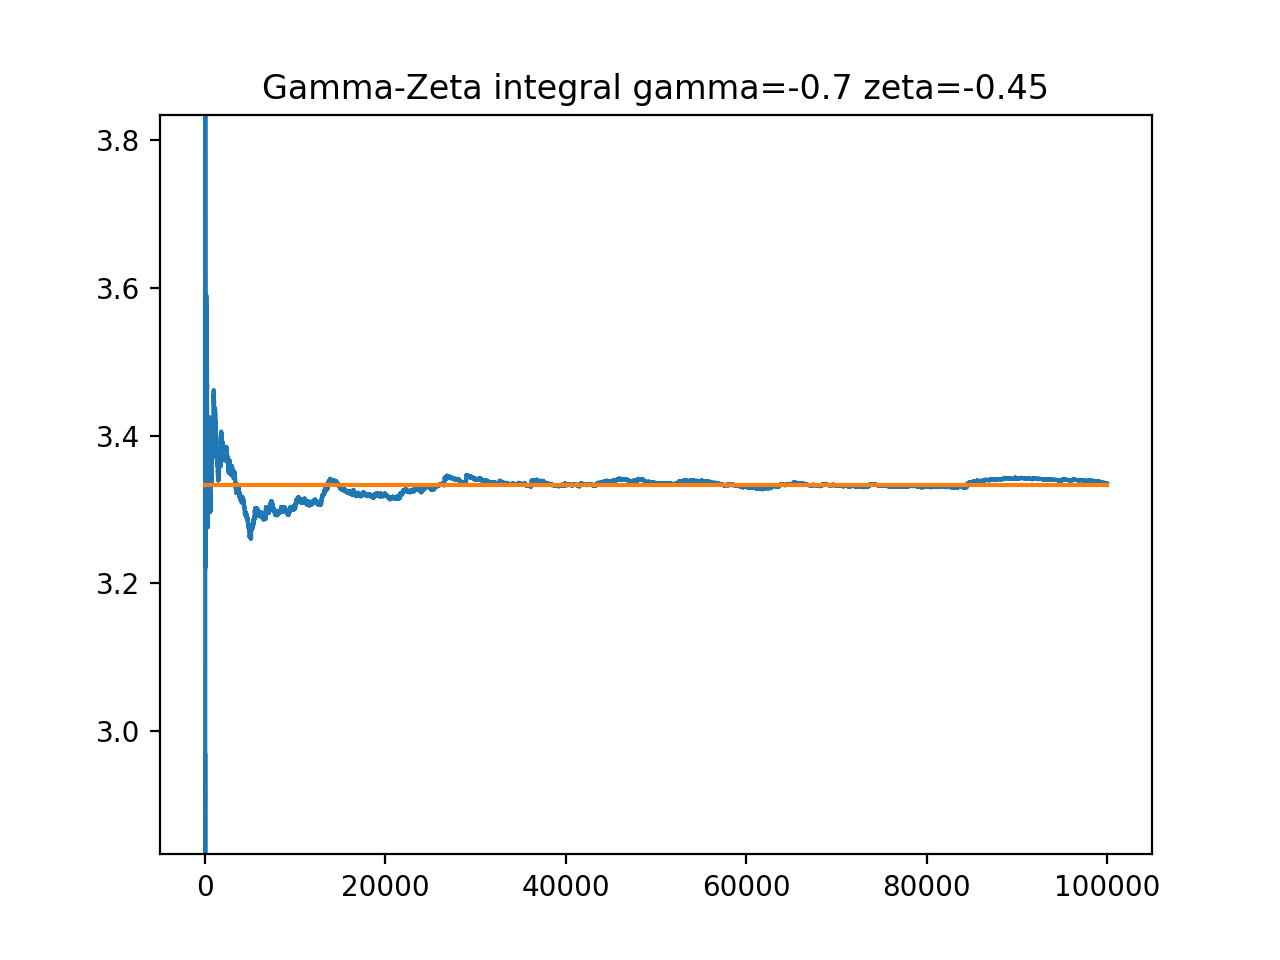

(2.833333333333333, 3.833333333333333)

In [19]:
N=100000
plt.plot(np.arange(1, N+1), direct_gama_zeta(gamma, zeta, N), np.array([1, N]), np.array([exact, exact]))

plt.title('Gamma-Zeta integral gamma={} zeta={}'.format(gamma, zeta))
plt.ylim((exact-0.5, exact+0.5))

Имаме сходимост при $N=100000$